In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import requests


# Webscraping external data

In [1076]:
import datetime as dt
train_dates = X_train.date.dt.date.unique()
dates = pd.date_range(train_dates[0], dt.datetime(2022, 1, 1), freq="D")
df_weather = pd.DataFrame()
sunshine_time = pd.Series(index=dates, dtype="object")
missing_dates = []

for date in dates.to_numpy():
    
    url = f'https://prevision-meteo.ch/climat/horaire/paris-montsouris/{date}'
    html = requests.get(url).content
    
    try:
        _, df_hour, df_day  = pd.read_html(html)
    except:
        missing_dates.append(date)
        continue
    
    df_hour.insert(0, ("Heure UTC1", "date"), date)
    date = pd.to_datetime(df_hour["Heure UTC1", "date"])
    time = pd.to_datetime(df_hour["Heure UTC1", "Heure UTC1"], format="%H:%M") - dt.datetime(1900,1,1)
    df_hour.drop(columns=df_hour.columns[0:2], inplace=True)
    df_hour.insert(0, "Datetime", date+time)
    
    #Total time of sunshine in 24 hour day
    sunshine_time.loc[date] = df_day.loc[0, "Ensoleillement4 [h]"][0]
       
    df_weather = pd.concat([df_weather, df_hour], ignore_index=True)
    
    
sunshine_time = pd.to_datetime(sunshine_time, format = "%H h %M min") - dt.datetime(1900,1,1)

In [1077]:
#The following days are missing in the database
print(missing_dates)

[numpy.datetime64('2020-11-10T00:00:00.000000000'), numpy.datetime64('2020-11-11T00:00:00.000000000')]


In [1078]:
df_weather.dtypes

Datetime                          datetime64[ns]
Température [°C]  2m.                    float64
                  Res.                   float64
                  Ros.                    object
Vent [km/h]       Dir.2                   object
                  Vit.                   float64
                  Moy.                    object
                  Raf.3                   object
Hum. [%]          Hum. [%]                object
Pres.4 [hPa]      Pres.4 [hPa]            object
Visi. [Km]        Visi. [Km]             float64
Nébu. [octa]      Nébu. [octa]            object
Préc.5 [mm]       Préc.5 [mm]             object
Cond.             Cond.                   object
dtype: object

In [1079]:
df_weather.head(10)

Datetime Température [°C]            Vent [km/h]                  \
                                   2m.  Res. Ros.       Dir.2 Vit. Moy. Raf.3   
0 2020-09-01 23:00:00             14.9  14.9  7.9         NNE  5.6   --  11.1   
1 2020-09-01 22:00:00             15.2  15.2  7.2         NNE  5.6   --  16.7   
2 2020-09-01 21:00:00             16.4  16.4  6.5          NE  7.4   --  14.8   
3 2020-09-01 20:00:00             17.1  17.1  6.3         NNE  7.4   --  16.7   
4 2020-09-01 19:00:00             18.5  18.5  6.7         NNE  5.6   --  13.0   
5 2020-09-01 18:00:00             18.9  18.9  7.0          NE  5.6   --  13.0   
6 2020-09-01 17:00:00             19.8  19.8  8.5           N  5.6   --  14.8   
7 2020-09-01 16:00:00             19.8  19.8  8.5          NE  5.6   --  13.0   
8 2020-09-01 15:00:00             19.8  19.8  7.8         NNE  7.4   --  13.0   
9 2020-09-01 14:00:00             21.9  21.9  7.3         ENE  3.7   --  11.1   

  Hum. [%]     Pres.4 [hPa] Visi. [Km] Nébu. [octa] Préc.5 [mm] Cond.  
  Hum. [%]     Pres.4 [hPa] Visi. [Km] Nébu. [octa] Préc.5 [mm] Cond.  
0       63   1019.1(0.6/3h)       20.0           --        0/1h    --  
1       59     1019(1.0/3h)       20.0           --        0/1h    --  
2       52   1018.9(1.2/3h)       20.0           --        0/3h    --  
3       49   1018.5(0.8/3h)       20.0           --        0/1h    --  
4       46   1017.9(0.4/3h)       20.0           --        0/1h    --  
5       46   1017.6(0.1/3h)       20.0           --  0/3h 0/12h    --  
6       48   1017.6(0.0/3h)       20.0           --        0/1h    --  
7       48  1017.5(-0.8/3h)       20.0           --        0/1h    --  
8       46  1017.5(-1.1/3h)       20.0           --        0/3h    --  
9       39  1017.5(-1.3/3h)       20.0           --        0/1h    --

### Information about columns of data

- Temperature --> only keeping 2m. is enough. It is the temperature measured 2 meters above the ground
- Vent (wind) --> 
    - Dir.2 is the direction of the wind. Convert it to dummies and keep it. 
    - Vit. is the speed of the wind during measurement
    - Raf.3 is the maximum speed. Probably better to drop this
- Humidity --> keep as is, convert to float
- Pressure --> Seperate the 2 different measures, keep both since they seem uncorrelated
    - One is in terms of hour but the hour value is all equal, so we can keep it
- Visibility --> Keep as is
- Nebu --> Cloud coverage, Nan column, we drop it
- Préc.5 [mm] --> Amount of rain binned. Turn into int categorical. Bin it.
- Cond. --> Some comments about the weather. Exists in very few columns and is in french. So we drop it

In [1080]:
df_external = df_weather.copy()
col_names = ["date", "Temperature (C)", "wind_temp", "dew_point_temp", "wind_dir", "wind_speed",
            "avg_wind_speed", "max_wind_speed", "Humidity", "Pressure", "Visibility", "Cloudiness",
            "Precipitation", "Comment"]
df_weather.columns = col_names
df_weather.head()

,date,Temperature (C),wind_temp,dew_point_temp,wind_dir,wind_speed,avg_wind_speed,max_wind_speed,Humidity,Pressure,Visibility,Cloudiness,Precipitation,Comment
0,2020-09-01 23:00:00,14.9,14.9,7.9,NNE,5.6,--,11.1,63,1019.1(0.6/3h),20.0,--,0/1h,--
1,2020-09-01 22:00:00,15.2,15.2,7.2,NNE,5.6,--,16.7,59,1019(1.0/3h),20.0,--,0/1h,--
2,2020-09-01 21:00:00,16.4,16.4,6.5,NE,7.4,--,14.8,52,1018.9(1.2/3h),20.0,--,0/3h,--
3,2020-09-01 20:00:00,17.1,17.1,6.3,NNE,7.4,--,16.7,49,1018.5(0.8/3h),20.0,--,0/1h,--
4,2020-09-01 19:00:00,18.5,18.5,6.7,NNE,5.6,--,13.0,46,1017.9(0.4/3h),20.0,--,0/1h,--


##### Temperature columns

0.4803212157844745


,wind_temp,Temperature (C)
wind_temp,1.000000,0.996283
Temperature (C),0.996283,1.000000


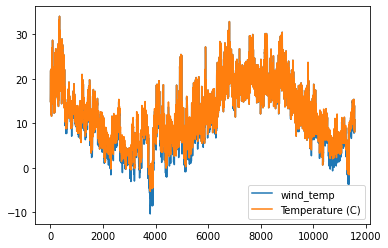

In [1081]:
df_weather[["wind_temp", "Temperature (C)"]].plot()
print((df_weather["Temperature (C)"] - df_weather.wind_temp).mean())
df_weather[["wind_temp", "Temperature (C)"]].corr()

Wind temperature is not worth keeping because of high correlation with regular temperature

In [1082]:
df_weather.drop(columns=["wind_temp", "dew_point_temp"], inplace=True)

<AxesSubplot:>

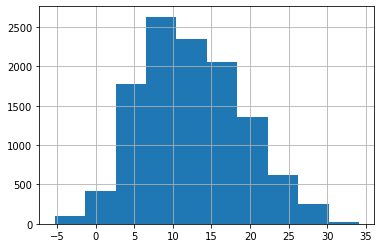

In [1083]:
df_weather["Temperature (C)"].hist()

##### Wind columns

In [1084]:
df_weather[["wind_dir", "wind_speed", "avg_wind_speed", "max_wind_speed"]].head()

,wind_dir,wind_speed,avg_wind_speed,max_wind_speed
0,NNE,5.6,--,11.1
1,NNE,5.6,--,16.7
2,NE,7.4,--,14.8
3,NNE,7.4,--,16.7
4,NNE,5.6,--,13.0


In [1085]:
# One-hot encode wind direction 
from sklearn.preprocessing import OneHotEncoder

df_weather.wind_dir.value_counts()
enc = OneHotEncoder()
winddir_dummies = enc.fit_transform(df_weather["wind_dir"].to_numpy().reshape(-1,1))
winddir_dummies.shape

#drop avg and max
df_weather.drop(columns=["avg_wind_speed", "max_wind_speed"], inplace=True)

##### Humidity Column

In [1086]:
hum = df_weather.Humidity
print("Nan value count:",hum[hum == "--"].count())

#Replace nan with the previous value
hum.replace("--", method="ffill", inplace=True)
print("Nan value count after replacement:",hum[hum == "--"].count())

Nan value count: 48
Nan value count after replacement: 0


<AxesSubplot:>

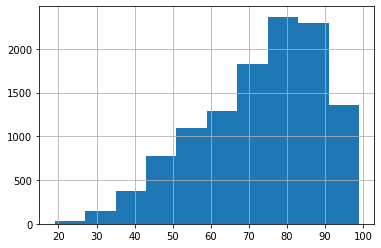

In [1087]:
df_weather["Humidity"] = hum.astype("float64")
df_weather.Humidity.hist()

In [1088]:
df_weather.drop(columns=["Cloudiness", "Comment"], inplace=True)

##### Pressure column

In [1089]:
pr = df_weather["Pressure"]

pr = [i.rstrip("h)").split("(") for i in pr]

df_weather["pressure1"] = pd.Series([float(i[0]) for i in pr], index=df_weather.index)
df_weather["pressure2"] = pd.Series([float(i[1].rstrip("/3")) for i in pr], index=df_weather.index)

df_weather.drop(columns=["Pressure"], inplace=True)

df_weather.head()

,date,Temperature (C),wind_dir,wind_speed,Humidity,Visibility,Precipitation,pressure1,pressure2
0,2020-09-01 23:00:00,14.9,NNE,5.6,63.0,20.0,0/1h,1019.1,0.6
1,2020-09-01 22:00:00,15.2,NNE,5.6,59.0,20.0,0/1h,1019.0,1.0
2,2020-09-01 21:00:00,16.4,NE,7.4,52.0,20.0,0/3h,1018.9,1.2
3,2020-09-01 20:00:00,17.1,NNE,7.4,49.0,20.0,0/1h,1018.5,0.8
4,2020-09-01 19:00:00,18.5,NNE,5.6,46.0,20.0,0/1h,1017.9,0.4


,pressure1,pressure2
pressure1,1.000000,0.069057
pressure2,0.069057,1.000000


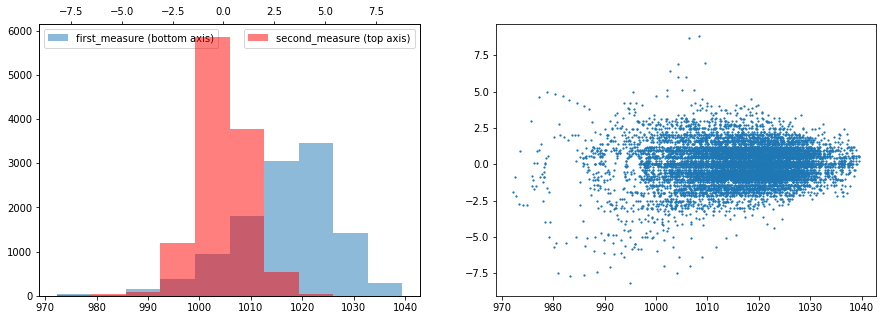

In [1090]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

ax[0].hist(df_weather["pressure1"], alpha=0.5, label="first_measure (bottom axis)")
ax[0].legend(loc=2)
ax2 = ax[0].twiny()
ax2.hist(df_weather["pressure2"], alpha=0.5, color="r", label="second_measure (top axis)")
ax2.legend(loc=1)
ax[1].scatter(df_weather["pressure1"], df_weather["pressure2"], s=1.5)
display(df_weather[["pressure1", "pressure2"]].corr())


We will only use the first measure, so drop the second

In [1091]:
df_weather.drop("pressure2", axis=1, inplace=True)

First, we seperated the two different measures of pressure, then converted them to floats and plotted them. The values are not correlated so we can use both for our analysis.

##### Precipitation Column

- h represents the hour 
- /1h means the rain that fell during 1 hour. So it might make sense to divide the numerator by the denominator
- Trace rainfall is defined as rainfall under 0.2 mm (or 0.05 in) which cannot be. measured by conventional types

- Operation logic for the column:
    - If there are multiple measures, take the one with the least hour interval, which is the first one

In [1092]:
df_weather.Precipitation.value_counts()

0/1h                      6467
0/3h                      1448
0/3h 0/6h                  644
trace/1h                   530
0.2/1h                     285
                          ... 
0.2/3h 0.8/12h 1.2/24h       1
0/3h 0.2/12h 1/24h           1
2/3h 4/12h 8/24h             1
1/3h 5/12h                   1
0/3h trace/12h 5.2/24h       1
Name: Precipitation, Length: 354, dtype: int64

In [1093]:
df_weather.Precipitation[df_weather.Precipitation == "trace/3h 0.2/12h 11.1/24h"] #This is worth checking over

2753    trace/3h 0.2/12h 11.1/24h
Name: Precipitation, dtype: object

In [1094]:
prec = df_weather.Precipitation.copy()

#Remove any extra data about longer time intervals
prec = pd.Series([i[0] for i in prec.str.split(" ")],
                 index=prec.index)

#Split  numerator and denominator and remove "h"
prec = pd.DataFrame(prec.str.split("/").to_list(), 
                    columns=["num", "den"],
                    index=prec.index)
prec["den"] = prec.den.str.strip("h")
prec["den"].value_counts()


1    7751
3    3828
Name: den, dtype: int64

In [1095]:
prec.num.value_counts().index

Index(['0', 'trace', '0.2', '0.4', '1', '0.6', '2', '0.8', '3', '4', '5', '6',
       '9', '7', '11', '16', '8', '10', '--', '0.7', '12', '0.9', '28', '13',
       '18', '14'],
      dtype='object')

- We know that trace is data very small. It is a safe assumption to replace it with 0.05 __?__
- We also see that we must deal with "--" in the column

In [1096]:
prec[prec.num == "--"] 

,num,den
3935,--,None
5452,--,None


There are 2 empty frames, we can replace them with the previous row value for both numerator and denominator by converting
them into nan values


In [1097]:
nan_ind = prec[prec.num == "--"].index #indices to replace
nan_ind
prec.loc[nan_ind] = np.nan
display(prec.loc[nan_ind])
prec.fillna(method="ffill", inplace=True)

,num,den
3935,NaN,NaN
5452,NaN,NaN


In [1098]:
#Convert trace into 0.001
prec.replace("trace", 0.001, inplace=True)
prec = prec.astype("float64")

<AxesSubplot:>

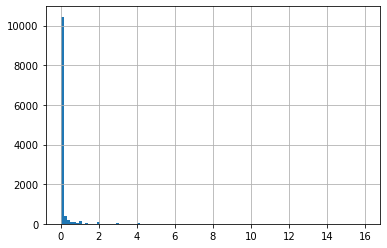

In [1099]:
#Lastly, divide the numerator of the 3 hour denominator columns with 3 to obtain rain for 1 hour
prec = pd.Series(np.where(prec.den == 3., prec.num/3, prec.num),
                index=prec.index)
prec.hist(bins=100)

The value are very uneven with a concentration on zero values, we will bin the variables.
- Categories
    - 0 --> x = 0
    - 1 --> trace (value it as e-3)
    - 2 --> 0.01 < x < 1
    - 3 --> 1 < x 
    
We can also create a dummy and try that

In [1100]:
(prec* 1e3).value_counts()

0.000000        9310
1.000000         530
0.333333         319
200.000000       285
66.666667        204
400.000000       123
1000.000000      121
333.333333        88
133.333333        86
600.000000        83
666.666667        77
2000.000000       69
800.000000        63
200.000000        53
266.666667        46
3000.000000       34
1333.333333       23
4000.000000       19
1666.666667       11
5000.000000        7
2333.333333        6
6000.000000        4
5333.333333        2
2666.666667        2
3333.333333        2
700.000000         2
11000.000000       2
3666.666667        2
4666.666667        1
10000.000000       1
8000.000000        1
16000.000000       1
4333.333333        1
9333.333333        1
300.000000         1
9000.000000        1
dtype: int64

<AxesSubplot:>

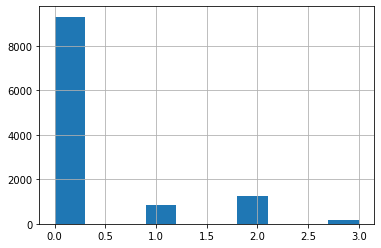

In [1101]:
prec_binned = pd.cut(prec*1e3, [-0.01, 0, 1, 1000, np.inf],
                     labels=[0, 1, 2, 3])
prec_binned.hist()

In [1102]:
df_weather["Precipitation"] = prec_binned

In [1103]:
df_weather.head()

,date,Temperature (C),wind_dir,wind_speed,Humidity,Visibility,Precipitation,pressure1
0,2020-09-01 23:00:00,14.9,NNE,5.6,63.0,20.0,0,1019.1
1,2020-09-01 22:00:00,15.2,NNE,5.6,59.0,20.0,0,1019.0
2,2020-09-01 21:00:00,16.4,NE,7.4,52.0,20.0,0,1018.9
3,2020-09-01 20:00:00,17.1,NNE,7.4,49.0,20.0,0,1018.5
4,2020-09-01 19:00:00,18.5,NNE,5.6,46.0,20.0,0,1017.9


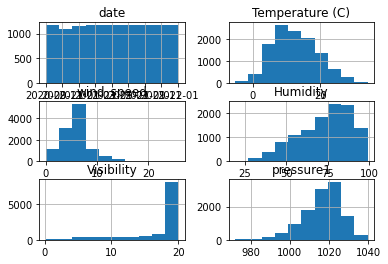

In [1104]:
df_weather.hist();

Take the log of visibility to make values more normal

<AxesSubplot:>

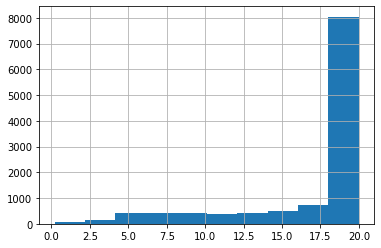

In [1105]:
#df_weather["Visibility"] = np.log(df_weather.Visibility)
df_weather["Visibility"].hist()

##### We fill the missing 2 dates from the provided external data 

In [1134]:
df_ext = pd.read_csv("submissions/external_data/external_data.csv",parse_dates=True)
df_ext.head()

,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,u,...,hnuage1,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4
0,7149,2021-01-01 00:00:00,100810,80,1,270,1.8,272.75,272.15,96,...,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7149,2021-01-01 03:00:00,100920,110,3,300,1.7,271.25,270.95,98,...,1500.0,2.0,3.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN
2,7149,2021-01-01 06:00:00,100950,30,3,290,2.6,271.95,271.65,98,...,480.0,4.0,6.0,2000.0,6.0,3.0,3000.0,NaN,NaN,NaN
3,7149,2021-01-01 09:00:00,101100,150,2,280,1.7,272.45,272.05,97,...,1740.0,3.0,3.0,2800.0,NaN,NaN,NaN,NaN,NaN,NaN
4,7149,2021-01-01 12:00:00,101110,30,0,50,1.0,276.95,274.15,82,...,330.0,4.0,6.0,570.0,7.0,6.0,810.0,NaN,NaN,NaN


In [1135]:
df_fill = df_weather.copy()

Reindex the dataframe so that the missing dates appear as nan instead of non-existent

In [1136]:
new_index = pd.date_range(df_fill.date.iloc[0], df_fill.date.iloc[-1], freq="H")
df_fill.set_index("date", inplace=True)
df_fill.index, new_index

(DatetimeIndex(['2020-09-01 23:00:00', '2020-09-01 22:00:00',
                '2020-09-01 21:00:00', '2020-09-01 20:00:00',
                '2020-09-01 19:00:00', '2020-09-01 18:00:00',
                '2020-09-01 17:00:00', '2020-09-01 16:00:00',
                '2020-09-01 15:00:00', '2020-09-01 14:00:00',
                ...
                '2022-01-01 09:00:00', '2022-01-01 08:00:00',
                '2022-01-01 07:00:00', '2022-01-01 06:00:00',
                '2022-01-01 05:00:00', '2022-01-01 04:00:00',
                '2022-01-01 03:00:00', '2022-01-01 02:00:00',
                '2022-01-01 01:00:00', '2022-01-01 00:00:00'],
               dtype='datetime64[ns]', name='date', length=11581, freq=None),
 DatetimeIndex(['2020-09-01 23:00:00', '2020-09-02 00:00:00',
                '2020-09-02 01:00:00', '2020-09-02 02:00:00',
                '2020-09-02 03:00:00', '2020-09-02 04:00:00',
                '2020-09-02 05:00:00', '2020-09-02 06:00:00',
                '2020-09-02 07:00

In [1137]:
missing_dates = new_index[~new_index.isin(df_fill.index)]
missing_dates

DatetimeIndex(['2020-09-23 06:00:00', '2020-10-08 06:00:00',
               '2020-10-12 06:00:00', '2020-10-19 09:00:00',
               '2020-10-19 10:00:00', '2020-10-23 06:00:00',
               '2020-10-24 06:00:00', '2020-10-30 06:00:00',
               '2020-11-09 02:00:00', '2020-11-09 03:00:00',
               ...
               '2021-10-29 06:00:00', '2021-11-08 06:00:00',
               '2021-11-10 06:00:00', '2021-11-15 06:00:00',
               '2021-11-21 06:00:00', '2021-11-25 06:00:00',
               '2021-11-30 06:00:00', '2021-12-03 06:00:00',
               '2021-12-09 06:00:00', '2021-12-20 06:00:00'],
              dtype='datetime64[ns]', length=134, freq=None)

In [1138]:
df_ext["date"] = pd.to_datetime(df_ext.date, format="%Y-%m-%d %H:%M:%S")
df_ext = df_ext.set_index("date", drop=True)
df_ext = df_ext.resample("H").first().fillna(method="ffill")
df_ext = df_ext[df_ext.index.isin(missing_dates)] 
df_ext

,numer_sta,pmer,tend,cod_tend,dd,ff,t,td,u,vv,...,hnuage1,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4
date,,,,,,,,,,,,,,,,,,,,,
2020-09-23 06:00:00,7149.0,100810.0,-30.0,5.0,210.0,3.7,288.45,286.95,91.0,18000.0,...,190.0,7.0,3.0,1260.0,8.0,9.0,3720.0,NaN,NaN,NaN
2020-10-08 06:00:00,7149.0,101880.0,-70.0,6.0,220.0,3.7,287.45,285.65,89.0,20000.0,...,300.0,8.0,6.0,1260.0,7.0,6.0,2400.0,2.0,0.0,8000.0
2020-10-12 06:00:00,7149.0,102490.0,-10.0,0.0,280.0,2.4,279.35,278.65,95.0,20000.0,...,6100.0,2.0,6.0,1800.0,6.0,6.0,1900.0,2.0,0.0,8000.0
2020-10-19 09:00:00,7149.0,102180.0,-10.0,8.0,140.0,2.0,281.75,280.05,89.0,10000.0,...,7500.0,7.0,0.0,7000.0,7.0,3.0,2520.0,2.0,0.0,8000.0
2020-10-19 10:00:00,7149.0,102180.0,-10.0,8.0,140.0,2.0,281.75,280.05,89.0,10000.0,...,7500.0,7.0,0.0,7000.0,7.0,3.0,2520.0,2.0,0.0,8000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-23 06:00:00,7149.0,102400.0,50.0,3.0,20.0,3.4,290.35,287.25,82.0,20000.0,...,510.0,7.0,3.0,3000.0,2.0,0.0,8000.0,5.0,0.0,6000.0
2021-08-27 06:00:00,7149.0,101950.0,40.0,3.0,360.0,2.8,287.95,285.05,83.0,20000.0,...,450.0,7.0,6.0,1980.0,2.0,0.0,8000.0,5.0,0.0,6000.0
2021-09-18 01:00:00,7149.0,101500.0,-20.0,8.0,0.0,0.0,287.45,284.95,85.0,25000.0,...,3000.0,2.0,0.0,8000.0,4.0,0.0,7000.0,2.0,9.0,360.0


In [1140]:
#Only keep relevant columns for our database
print(df_weather.columns)
df_ext = df_ext[[ "t", "dd", "ff", "u", "vv", "rr1", "pmer"]]
df_ext

Index(['date', 'Temperature (C)', 'wind_dir', 'wind_speed', 'Humidity',
       'Visibility', 'Precipitation', 'pressure1'],
      dtype='object')


,t,dd,ff,u,vv,rr1,pmer
date,,,,,,,
2020-09-23 06:00:00,288.45,210.0,3.7,91.0,18000.0,0.0,100810.0
2020-10-08 06:00:00,287.45,220.0,3.7,89.0,20000.0,-0.1,101880.0
2020-10-12 06:00:00,279.35,280.0,2.4,95.0,20000.0,0.0,102490.0
2020-10-19 09:00:00,281.75,140.0,2.0,89.0,10000.0,0.0,102180.0
2020-10-19 10:00:00,281.75,140.0,2.0,89.0,10000.0,0.0,102180.0
...,...,...,...,...,...,...,...
2021-08-23 06:00:00,290.35,20.0,3.4,82.0,20000.0,0.0,102400.0
2021-08-27 06:00:00,287.95,360.0,2.8,83.0,20000.0,0.0,101950.0
2021-09-18 01:00:00,287.45,0.0,0.0,85.0,25000.0,0.0,101500.0


In [1142]:
df_ext.columns = df_weather.iloc[:,1:8].columns
df_ext

,Temperature (C),wind_dir,wind_speed,Humidity,Visibility,Precipitation,pressure1
date,,,,,,,
2020-09-23 06:00:00,288.45,210.0,3.7,91.0,18000.0,0.0,100810.0
2020-10-08 06:00:00,287.45,220.0,3.7,89.0,20000.0,-0.1,101880.0
2020-10-12 06:00:00,279.35,280.0,2.4,95.0,20000.0,0.0,102490.0
2020-10-19 09:00:00,281.75,140.0,2.0,89.0,10000.0,0.0,102180.0
2020-10-19 10:00:00,281.75,140.0,2.0,89.0,10000.0,0.0,102180.0
...,...,...,...,...,...,...,...
2021-08-23 06:00:00,290.35,20.0,3.4,82.0,20000.0,0.0,102400.0
2021-08-27 06:00:00,287.95,360.0,2.8,83.0,20000.0,0.0,101950.0
2021-09-18 01:00:00,287.45,0.0,0.0,85.0,25000.0,0.0,101500.0


In [1143]:
df_ext

,Temperature (C),wind_dir,wind_speed,Humidity,Visibility,Precipitation,pressure1
date,,,,,,,
2020-09-23 06:00:00,288.45,210.0,3.7,91.0,18000.0,0.0,100810.0
2020-10-08 06:00:00,287.45,220.0,3.7,89.0,20000.0,-0.1,101880.0
2020-10-12 06:00:00,279.35,280.0,2.4,95.0,20000.0,0.0,102490.0
2020-10-19 09:00:00,281.75,140.0,2.0,89.0,10000.0,0.0,102180.0
2020-10-19 10:00:00,281.75,140.0,2.0,89.0,10000.0,0.0,102180.0
...,...,...,...,...,...,...,...
2021-08-23 06:00:00,290.35,20.0,3.4,82.0,20000.0,0.0,102400.0
2021-08-27 06:00:00,287.95,360.0,2.8,83.0,20000.0,0.0,101950.0
2021-09-18 01:00:00,287.45,0.0,0.0,85.0,25000.0,0.0,101500.0


Convert temperature to Celcius from Kelvin

In [1144]:
df_ext["Temperature (C)"] = df_ext["Temperature (C)"] - 273.15

C:\Users\Dell\AppData\Local\Temp\ipykernel_12720\189179842.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ext["Temperature (C)"] = df_ext["Temperature (C)"] - 273.15


Wind direction will be assumed constant from main data

In [1145]:
df_ext["wind_dir"] = np.nan

C:\Users\Dell\AppData\Local\Temp\ipykernel_12720\2215624227.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ext["wind_dir"] = np.nan


In [1146]:
#Check mean of wind and see if measures match
print(df_weather.wind_speed.mean())
print(df_weather.Humidity.mean())

5.9330886797340465
72.43925395043605


In [1148]:
# Apply transform to visibility,convert to kilometers

df_ext["Visibility"] = df_ext["Visibility"] / 1000
df_ext["Visibility"] = df_ext["Visibility"].mask(df_ext.Visibility > 20, 20)
df_ext.Visibility

C:\Users\Dell\AppData\Local\Temp\ipykernel_12720\3342575078.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ext["Visibility"] = df_ext["Visibility"].mask(df_ext.Visibility > 20, 20)


date
2020-09-23 06:00:00    18.00
2020-10-08 06:00:00    20.00
2020-10-12 06:00:00    20.00
2020-10-19 09:00:00    10.00
2020-10-19 10:00:00    10.00
                       ...  
2021-08-23 06:00:00    20.00
2021-08-27 06:00:00    20.00
2021-09-18 01:00:00    20.00
2021-09-19 06:00:00    18.47
2021-09-26 06:00:00     8.00
Name: Visibility, Length: 123, dtype: float64

In [1149]:
#For precipitation, turn negative values into 0 and divide all by 3 to ensure consistency
df_ext["Precipitation"] = df_ext.Precipitation.mask(df_ext.Precipitation < 0, 0) / 3
df_ext.Precipitation

C:\Users\Dell\AppData\Local\Temp\ipykernel_12720\1412845689.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ext["Precipitation"] = df_ext.Precipitation.mask(df_ext.Precipitation < 0, 0) / 3


date
2020-09-23 06:00:00    0.0
2020-10-08 06:00:00    0.0
2020-10-12 06:00:00    0.0
2020-10-19 09:00:00    0.0
2020-10-19 10:00:00    0.0
                      ... 
2021-08-23 06:00:00    0.0
2021-08-27 06:00:00    0.0
2021-09-18 01:00:00    0.0
2021-09-19 06:00:00    0.0
2021-09-26 06:00:00    0.0
Name: Precipitation, Length: 123, dtype: float64

In [1151]:
df_ext.Precipitation.value_counts()

0.000000    116
0.066667      3
0.200000      3
0.133333      1
Name: Precipitation, dtype: int64

In [1182]:
#Pressure unit it Hpa on new data, we need to convert it to pa 
# 1Hpa = 100pa
df_ext["pressure1"] = df_ext.pressure1 / 100
df_ext["pressure1"].mean(), df_fill["pressure1"].mean()

C:\Users\Dell\AppData\Local\Temp\ipykernel_12720\2896470553.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ext["pressure1"] = df_ext.pressure1 / 100


(1020.659349593496, 1016.7128659010448)

Now join the 2 dataframes

In [1153]:
df_ext.isna().sum()

Temperature (C)      0
wind_dir           123
wind_speed           0
Humidity             0
Visibility           0
Precipitation        0
pressure1            0
dtype: int64

In [1162]:
#Reindex df_weather with new index and join 2 dataframes
df_new = pd.concat([df_fill, df_ext]).sort_index()
df_new.isna().sum()

Temperature (C)      0
wind_dir           123
wind_speed           0
Humidity             0
Visibility           0
Precipitation        0
pressure1            0
dtype: int64

In [1163]:
#Fill the missing values in wind_dir with previous values
df_new.fillna(method="ffill", inplace=True)
df_new.isna().sum()

Temperature (C)    0
wind_dir           0
wind_speed         0
Humidity           0
Visibility         0
Precipitation      0
pressure1          0
dtype: int64

##### Visualize the data could be drwan from the same distribution

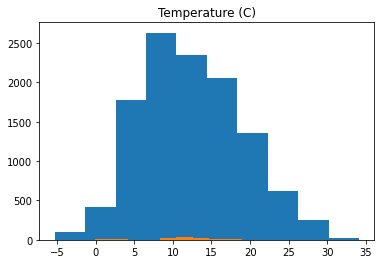

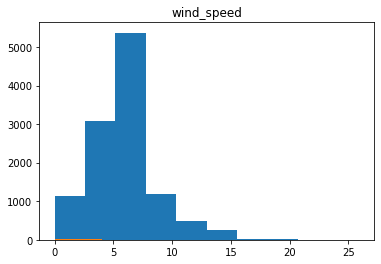

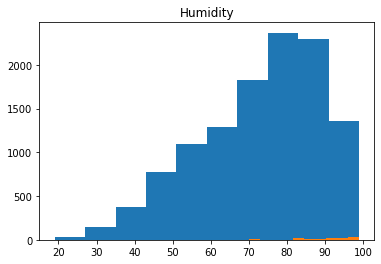

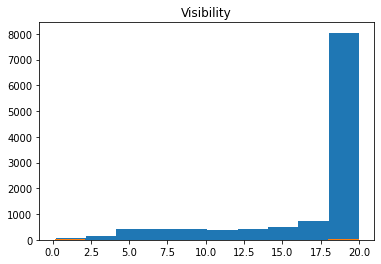

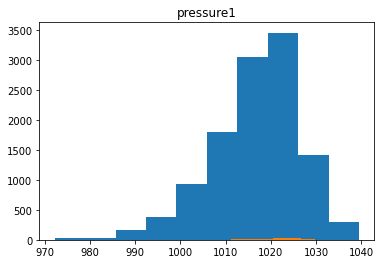

In [1183]:
#Draw histograms for each data point to check for outliers
for col in df_weather.select_dtypes(include=np.number).columns:
    m = df_weather[col].copy()
    s = df_ext[col].copy()
    plt.figure(col)
    plt.title(col)
    plt.hist(m)
    plt.hist(s)

The values for the new values from other data and old data match in scale

In [1188]:
df_new.dtypes

Temperature (C)    float64
wind_dir            object
wind_speed         float64
Humidity           float64
Visibility         float64
Precipitation      float64
pressure1          float64
dtype: object

##### Sunshine Time

In [1184]:
nan_val = sunshine_time.value_counts().index[0]
sunshine_time

2020-09-01   0 days 06:06:00
2020-09-02   0 days 09:30:00
2020-09-03   0 days 05:30:00
2020-09-04   0 days 10:42:00
2020-09-05   0 days 02:42:00
                   ...      
2021-12-28   0 days 02:12:00
2021-12-29   0 days 00:00:00
2021-12-30   0 days 01:54:00
2021-12-31   0 days 06:06:00
2022-01-01   0 days 00:00:00
Freq: D, Length: 488, dtype: timedelta64[ns]

<AxesSubplot:>

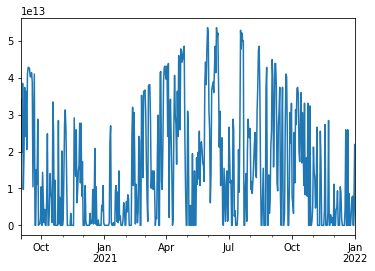

In [1185]:
sunshine_time.plot()

Text(0.5, 1.0, 'Daily Sunshine Time in Seconds')

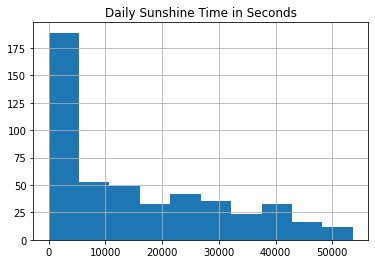

In [1186]:
sunshine_secs = sunshine_time.dt.seconds.rename("sunshine_time")
sunshine_secs.hist()
plt.title("Daily Sunshine Time in Seconds")

In [1191]:
df_weather = df_new.reset_index().copy()

In [1192]:
df_weather["date_only"] = pd.to_datetime(df_weather.date.dt.date)
df_weather.date_only.isin(sunshine_time.index).all()

True

In [1193]:
#Create a temporary date only column to merge sunshine_time
df_weather["date_only"] = pd.to_datetime(df_weather.date.dt.date)

df_weather = df_weather.join(sunshine_secs, on="date_only", rsuffix='_right')
df_weather.drop("date_only", axis=1, inplace=True)
df_weather.head()




,date,Temperature (C),wind_dir,wind_speed,Humidity,Visibility,Precipitation,pressure1,sunshine_time
0,2020-09-01 00:00:00,13.9,N,3.7,76.0,20.0,0.0,1020.4,21960.0
1,2020-09-01 01:00:00,13.6,NNO,1.9,77.0,20.0,0.0,1020.1,21960.0
2,2020-09-01 02:00:00,13.0,ONO,1.9,79.0,20.0,0.0,1019.9,21960.0
3,2020-09-01 03:00:00,12.9,NO,1.9,81.0,20.0,0.0,1019.8,21960.0
4,2020-09-01 04:00:00,12.4,ONO,3.7,83.0,20.0,0.0,1019.5,21960.0


In [1195]:
df_weather["sunshine_time"] = df_weather["sunshine_time"].fillna(method="ffill")
df_weather.sunshine_time.isna().sum()

0

##### Daylight time in seconds

In [1196]:
#The month and the year as a string
mthyr = df_weather.date.dt.month.astype(str) + "-" + df_weather.date.dt.year.astype(str)
mthyr = mthyr.unique()
mthyr


array(['9-2020', '10-2020', '11-2020', '12-2020', '1-2021', '2-2021',
       '3-2021', '4-2021', '5-2021', '6-2021', '7-2021', '8-2021',
       '9-2021', '10-2021', '11-2021', '12-2021', '1-2022'], dtype=object)

In [1197]:
#Scrape data for day times
suntimes = pd.DataFrame(columns=["date", "suntime"])
for my in mthyr[:-1]:
    month, year = my.split("-")[0], my.split("-")[1]  
    sun = pd.read_html(f"https://www.timeanddate.com/sun/france/paris?month={month}&year={year}")[1].iloc[:, [0, 3]]
    sun.columns = ["date", "suntime"]
    
    #Remove possible rows with additional data
    row_lens = [len(i) for i in sun["date"]] #check for the lengths, length more than 2 indicates text
    to_drop = np.where(np.array(row_lens) > 2)
    to_drop = [i for i in to_drop[0]]

    sun.drop(to_drop, inplace=True)
    
    sun["date"] = pd.to_datetime(sun.date + "-" + my, format="%d-%m-%Y")
    suntimes = pd.concat([suntimes, sun], ignore_index=True)
    
suntimes


,date,suntime
0,2020-09-01,13:24:15
1,2020-09-02,13:20:47
2,2020-09-03,13:17:18
3,2020-09-04,13:13:49
4,2020-09-05,13:10:19
...,...,...
482,2021-12-27,8:16:27
483,2021-12-28,8:17:03
484,2021-12-29,8:17:45
485,2021-12-30,8:18:32


In [1198]:
#Check for nans
suntimes.isna().sum(), suntimes.dtypes

(date       0
 suntime    0
 dtype: int64,
 date       datetime64[ns]
 suntime            object
 dtype: object)

In [1199]:
pd.to_timedelta(suntimes.suntime)

0     0 days 13:24:15
1     0 days 13:20:47
2     0 days 13:17:18
3     0 days 13:13:49
4     0 days 13:10:19
            ...      
482   0 days 08:16:27
483   0 days 08:17:03
484   0 days 08:17:45
485   0 days 08:18:32
486   0 days 08:19:25
Name: suntime, Length: 487, dtype: timedelta64[ns]

In [1200]:
suntimes["suntime"] = pd.to_timedelta(suntimes.suntime).dt.seconds
suntimes.suntime.value_counts()

31530    2
58249    2
29693    2
55703    1
56256    1
        ..
35006    1
34816    1
34628    1
34442    1
29965    1
Name: suntime, Length: 484, dtype: int64

In [1201]:
df_weather["date_only"] = pd.to_datetime(df_weather.date.dt.date)

suntimes = suntimes[suntimes.date.isin(df_weather.date_only)]
suntimes = suntimes.set_index("date", drop=True)

In [1202]:
#Join suntimes to main data

df_weather = df_weather.join(suntimes, on="date_only", rsuffix='_right')

df_weather.drop("date_only", axis=1, inplace=True)
df_weather.head()


,date,Temperature (C),wind_dir,wind_speed,Humidity,Visibility,Precipitation,pressure1,sunshine_time,suntime
0,2020-09-01 00:00:00,13.9,N,3.7,76.0,20.0,0.0,1020.4,21960.0,48255.0
1,2020-09-01 01:00:00,13.6,NNO,1.9,77.0,20.0,0.0,1020.1,21960.0,48255.0
2,2020-09-01 02:00:00,13.0,ONO,1.9,79.0,20.0,0.0,1019.9,21960.0,48255.0
3,2020-09-01 03:00:00,12.9,NO,1.9,81.0,20.0,0.0,1019.8,21960.0,48255.0
4,2020-09-01 04:00:00,12.4,ONO,3.7,83.0,20.0,0.0,1019.5,21960.0,48255.0


In [1203]:
#first day of 2022, we don't need it
to_drop = df_weather[df_weather.suntime.isna()].date.dt.date.index

df_weather.drop(to_drop, inplace=True)
df_weather

,date,Temperature (C),wind_dir,wind_speed,Humidity,Visibility,Precipitation,pressure1,sunshine_time,suntime
0,2020-09-01 00:00:00,13.9,N,3.7,76.0,20.0,0.0,1020.4,21960.0,48255.0
1,2020-09-01 01:00:00,13.6,NNO,1.9,77.0,20.0,0.0,1020.1,21960.0,48255.0
2,2020-09-01 02:00:00,13.0,ONO,1.9,79.0,20.0,0.0,1019.9,21960.0,48255.0
3,2020-09-01 03:00:00,12.9,NO,1.9,81.0,20.0,0.0,1019.8,21960.0,48255.0
4,2020-09-01 04:00:00,12.4,ONO,3.7,83.0,20.0,0.0,1019.5,21960.0,48255.0
...,...,...,...,...,...,...,...,...,...,...
11675,2021-12-31 19:00:00,11.9,OSO,3.7,90.0,18.0,0.0,1026.5,21960.0,29965.0
11676,2021-12-31 20:00:00,12.0,O,5.6,91.0,17.0,0.0,1026.6,21960.0,29965.0
11677,2021-12-31 21:00:00,12.2,O,3.7,92.0,14.0,0.0,1026.6,21960.0,29965.0
11678,2021-12-31 22:00:00,12.0,O,1.9,91.0,14.0,0.0,1026.7,21960.0,29965.0


<AxesSubplot:title={'center':'day length for each day'}, xlabel='date'>

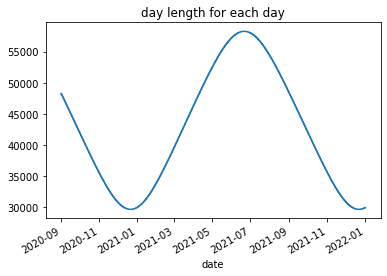

In [1204]:
df_weather.set_index("date").suntime.plot(title="day length for each day")

##### Covid Data

In [1205]:
df_covid = pd.read_csv("owid-covid-data.csv")
df_covid.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


In [1206]:
df_covid.dtypes

iso_code                                    object
continent                                   object
location                                    object
date                                        object
total_cases                                float64
                                            ...   
population                                 float64
excess_mortality_cumulative_absolute       float64
excess_mortality_cumulative                float64
excess_mortality                           float64
excess_mortality_cumulative_per_million    float64
Length: 67, dtype: object

In [1207]:
#Filter France and dates
df_weather["date_only"] = pd.to_datetime(df_weather.date.dt.date)

df_covid = df_covid[df_covid.location == "France"].reset_index(drop=True)
df_covid["date"] = pd.to_datetime(df_covid.date, format="%Y-%m-%d")

df_covid = df_covid[df_covid.date.isin(df_weather.date_only)].reset_index()
df_covid = df_covid[["date", "new_cases"]]




array([[<AxesSubplot:title={'center':'new_cases'}>]], dtype=object)

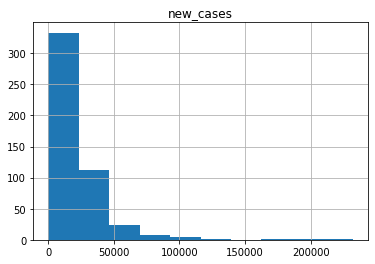

In [1208]:
df_covid.set_index("date", drop=True).hist()

<AxesSubplot:xlabel='date'>

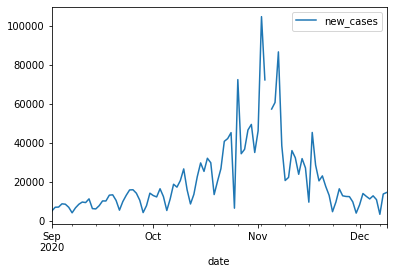

In [1209]:
df_covid.set_index("date").iloc[0:100].plot()

In [1210]:
#Merge new covid cases with new data
df_covid = df_covid.set_index("date", drop=True)
df_weather = df_weather.join(df_covid,on="date_only", rsuffix='_right')
df_weather.head()

,date,Temperature (C),wind_dir,wind_speed,Humidity,Visibility,Precipitation,pressure1,sunshine_time,suntime,date_only,new_cases
0,2020-09-01 00:00:00,13.9,N,3.7,76.0,20.0,0.0,1020.4,21960.0,48255.0,2020-09-01,5104.0
1,2020-09-01 01:00:00,13.6,NNO,1.9,77.0,20.0,0.0,1020.1,21960.0,48255.0,2020-09-01,5104.0
2,2020-09-01 02:00:00,13.0,ONO,1.9,79.0,20.0,0.0,1019.9,21960.0,48255.0,2020-09-01,5104.0
3,2020-09-01 03:00:00,12.9,NO,1.9,81.0,20.0,0.0,1019.8,21960.0,48255.0,2020-09-01,5104.0
4,2020-09-01 04:00:00,12.4,ONO,3.7,83.0,20.0,0.0,1019.5,21960.0,48255.0,2020-09-01,5104.0


In [1211]:
df_weather[df_weather.new_cases.isna()].date_only.unique() 

array(['2020-11-04T00:00:00.000000000', '2021-05-20T00:00:00.000000000'],
      dtype='datetime64[ns]')

2 dates have missing data for new covid cases

In [1212]:
df_weather["new_cases"] = df_weather["new_cases"].fillna(method="ffill") 

In [1213]:
df_weather.drop("date_only", axis=1, inplace=True)

In [1214]:
df_weather.Precipitation.value_counts()

0.000000    9406
2.000000    1232
1.000000     845
3.000000     190
0.066667       3
0.200000       3
0.133333       1
Name: Precipitation, dtype: int64

In [1216]:
df_weather.dtypes

date               datetime64[ns]
Temperature (C)           float64
wind_dir                   object
wind_speed                float64
Humidity                  float64
Visibility                float64
Precipitation             float64
pressure1                 float64
sunshine_time             float64
suntime                   float64
new_cases                 float64
dtype: object

In [1217]:
df_weather.head()

,date,Temperature (C),wind_dir,wind_speed,Humidity,Visibility,Precipitation,pressure1,sunshine_time,suntime,new_cases
0,2020-09-01 00:00:00,13.9,N,3.7,76.0,20.0,0.0,1020.4,21960.0,48255.0,5104.0
1,2020-09-01 01:00:00,13.6,NNO,1.9,77.0,20.0,0.0,1020.1,21960.0,48255.0,5104.0
2,2020-09-01 02:00:00,13.0,ONO,1.9,79.0,20.0,0.0,1019.9,21960.0,48255.0,5104.0
3,2020-09-01 03:00:00,12.9,NO,1.9,81.0,20.0,0.0,1019.8,21960.0,48255.0,5104.0
4,2020-09-01 04:00:00,12.4,ONO,3.7,83.0,20.0,0.0,1019.5,21960.0,48255.0,5104.0


##### Night time dummy

In [15]:
import datetime as dt
#df_weather["hour"] = 
hours = pd.to_datetime(df_weather.date).dt.hour

cond = (hours >= 20)|(hours <= 7)
night_time = np.where(cond, 1, 0)
df_weather["night_time"] = night_time
df_weather.head()

,Unnamed: 0,date,Temperature (C),wind_dir,wind_speed,Humidity,Visibility,Precipitation,pressure1,sunshine_time,suntime,new_cases,date_only,holidays2,night_time
0,0,2020-09-01 00:00:00,13.9,N,3.7,76.0,20.0,0.0,1020.4,21960.0,48255.0,5104.0,2020-09-01,0,1
1,1,2020-09-01 01:00:00,13.6,NNO,1.9,77.0,20.0,0.0,1020.1,21960.0,48255.0,5104.0,2020-09-01,0,1
2,2,2020-09-01 02:00:00,13.0,ONO,1.9,79.0,20.0,0.0,1019.9,21960.0,48255.0,5104.0,2020-09-01,0,1
3,3,2020-09-01 03:00:00,12.9,NO,1.9,81.0,20.0,0.0,1019.8,21960.0,48255.0,5104.0,2020-09-01,0,1
4,4,2020-09-01 04:00:00,12.4,ONO,3.7,83.0,20.0,0.0,1019.5,21960.0,48255.0,5104.0,2020-09-01,0,1


##### Weekend Dummy

In [22]:
df_weather["weekday"].value_counts()

2    1679
1    1678
3    1678
4    1678
5    1656
6    1655
0    1653
Name: weekday, dtype: int64

In [25]:
df_weather["weekday"] = pd.to_datetime(df_weather.date).dt.dayofweek
df_weather["date"] = pd.to_datetime(df_weather.date, format=("%Y-%m-%d %H:%M:%S"))
df_weather["weekend_dummy"] = np.where(df_weather.weekday.isin([5, 6]), 1, 0)
df_weather.weekend_dummy.value_counts()

0    8366
1    3311
Name: weekend_dummy, dtype: int64

In [27]:
print(df_weather.weekend_dummy.value_counts()[0] / df_weather.weekend_dummy.value_counts().sum())
5/7

0.716451143273101


0.7142857142857143

In [31]:
df_weather.dtypes

Unnamed: 0                  int64
date               datetime64[ns]
Temperature (C)           float64
wind_dir                   object
wind_speed                float64
Humidity                  float64
Visibility                float64
Precipitation             float64
pressure1                 float64
sunshine_time             float64
suntime                   float64
new_cases                 float64
date_only                  object
holidays2                   int64
night_time                  int32
weekday                     int64
weekend_dummy               int32
dtype: object

##### Holiday Data
- Add holidays to the external data

In [1219]:
import holidays

In [1220]:
holidays2 = holidays.country_holidays('FR')


In [1221]:
holidays2 = pd.Series([i in holidays2 for i in df_weather.date.dt.date.unique()],
                    index=pd.to_datetime(df_weather.date.dt.date.unique()),
                    name="holidays2").astype("int")
holidays2

2020-09-01    0
2020-09-02    0
2020-09-03    0
2020-09-04    0
2020-09-05    0
             ..
2021-12-27    0
2021-12-28    0
2021-12-29    0
2021-12-30    0
2021-12-31    0
Name: holidays2, Length: 487, dtype: int32

In [1222]:
holidays2.value_counts()

0    473
1     14
Name: holidays2, dtype: int64

In [1223]:
df_weather["date_only"] = pd.to_datetime(df_weather.date.dt.date)
df_weather.dtypes

date               datetime64[ns]
Temperature (C)           float64
wind_dir                   object
wind_speed                float64
Humidity                  float64
Visibility                float64
Precipitation             float64
pressure1                 float64
sunshine_time             float64
suntime                   float64
new_cases                 float64
date_only          datetime64[ns]
dtype: object

In [1224]:
holidays2.index.isin(df_weather.date_only).all()
holidays2

2020-09-01    0
2020-09-02    0
2020-09-03    0
2020-09-04    0
2020-09-05    0
             ..
2021-12-27    0
2021-12-28    0
2021-12-29    0
2021-12-30    0
2021-12-31    0
Name: holidays2, Length: 487, dtype: int32

In [1225]:
df_weather = df_weather.join(holidays2, on="date_only", how="left")
df_weather

,date,Temperature (C),wind_dir,wind_speed,Humidity,Visibility,Precipitation,pressure1,sunshine_time,suntime,new_cases,date_only,holidays2
0,2020-09-01 00:00:00,13.9,N,3.7,76.0,20.0,0.0,1020.4,21960.0,48255.0,5104.0,2020-09-01,0
1,2020-09-01 01:00:00,13.6,NNO,1.9,77.0,20.0,0.0,1020.1,21960.0,48255.0,5104.0,2020-09-01,0
2,2020-09-01 02:00:00,13.0,ONO,1.9,79.0,20.0,0.0,1019.9,21960.0,48255.0,5104.0,2020-09-01,0
3,2020-09-01 03:00:00,12.9,NO,1.9,81.0,20.0,0.0,1019.8,21960.0,48255.0,5104.0,2020-09-01,0
4,2020-09-01 04:00:00,12.4,ONO,3.7,83.0,20.0,0.0,1019.5,21960.0,48255.0,5104.0,2020-09-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11675,2021-12-31 19:00:00,11.9,OSO,3.7,90.0,18.0,0.0,1026.5,21960.0,29965.0,232200.0,2021-12-31,0
11676,2021-12-31 20:00:00,12.0,O,5.6,91.0,17.0,0.0,1026.6,21960.0,29965.0,232200.0,2021-12-31,0
11677,2021-12-31 21:00:00,12.2,O,3.7,92.0,14.0,0.0,1026.6,21960.0,29965.0,232200.0,2021-12-31,0
11678,2021-12-31 22:00:00,12.0,O,1.9,91.0,14.0,0.0,1026.7,21960.0,29965.0,232200.0,2021-12-31,0


In [1226]:
df_weather.holidays2.value_counts()

0    11344
1      336
Name: holidays2, dtype: int64

In [1227]:
df_weather.isna().sum()

date               0
Temperature (C)    0
wind_dir           0
wind_speed         0
Humidity           0
Visibility         0
Precipitation      0
pressure1          0
sunshine_time      0
suntime            0
new_cases          0
date_only          0
holidays2          0
dtype: int64

##### Data is ready to deploy

# External data csv: 

Working with the external data provided by the project by default

### Save data as csv file

In [29]:
df_weather.drop("date_only", axis=1).to_csv("external_data1.csv")

In [1230]:
print(df_weather.date.shape, df_weather.date.unique().shape)
df_weather = df_weather.loc[~df_weather.date.duplicated(),:]
print(df_weather.date.shape, df_weather.date.unique().shape)

(11680,) (11677,)
(11677,) (11677,)


In [1231]:
df_weather.to_csv("external_data1.csv")

In [9]:
import problem

X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df_weather = pd.read_csv("external_data1.csv").drop(df_weather.columns[:2], axis=1)
y_train.shape, df_weather.shape


((455163,), (11677, 15))

In [24]:
y_train.isna()

date
2020-09-01 01:00:00    True
2020-09-01 01:00:00    True
2020-09-01 01:00:00    True
2020-09-01 01:00:00    True
2020-09-01 01:00:00    True
                       ... 
2021-08-09 23:00:00    True
2021-08-09 23:00:00    True
2021-08-09 23:00:00    True
2021-08-09 23:00:00    True
2021-08-09 23:00:00    True
Name: log_bike_count, Length: 455163, dtype: bool

In [22]:
y_train = pd.Series(y_train, index=X_train.date, name="log_bike_count")
df_weather.join(y_train, on="date")

ValueError: You are trying to merge on object and datetime64[ns] columns. If you wish to proceed you should use pd.concat

In [8]:
fig, axes = plt.subplots(15, 15, sharex=True, figsize=(16,8))

for col in df_weather.columns:
    sns.regplot(x=df_weather[col], y=)

15

In [8]:
df_weather.drop(df_weather.columns[:2], axis=1).describe()

,Temperature (C),wind_speed,Humidity,Visibility,Precipitation,pressure1,sunshine_time,suntime,new_cases,holidays2,night_time,weekday,weekend_dummy
count,11677.000000,11677.000000,11677.000000,11677.000000,11677.000000,11677.000000,11677.000000,11677.000000,11677.000000,11677.000000,11677.000000,11677.000000,11677.000000
mean,12.404102,5.898501,72.587651,17.301999,0.332271,2081.098758,15198.616083,42260.430419,20910.007022,0.028775,0.499529,2.996660,0.283549
std,6.547071,2.830339,15.901040,4.624897,0.728345,10316.873521,15424.615832,9516.948416,24746.543161,0.167179,0.500021,1.994873,0.450740
min,-5.300000,0.000000,19.000000,0.130000,0.000000,972.200000,0.000000,29689.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.600000,3.700000,62.000000,17.000000,0.000000,1011.400000,0.000000,33185.000000,6229.000000,0.000000,0.000000,1.000000,0.000000
50%,11.700000,5.600000,75.000000,20.000000,0.000000,1018.200000,10800.000000,41249.000000,14646.000000,0.000000,0.000000,3.000000,0.000000
75%,17.100000,7.400000,85.000000,20.000000,0.000000,1023.500000,26640.000000,50608.000000,25410.000000,0.000000,1.000000,5.000000,1.000000
max,34.100000,25.900000,99.000000,20.000000,3.000000,102980.000000,53640.000000,58249.000000,232200.000000,1.000000,1.000000,6.000000,1.000000


In [9]:
from pandas_profiling import ProfileReport
ProfileReport(df_weather, title="Pandas Profiling Report").to_file("external_data.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\Dell\AppData\Roaming\Python\Python39\site-packages\pandas_profiling\model\pandas\summary_pandas.py:80: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  args = [(name, series) for name, series in df.iteritems()]
C:\Users\Dell\AppData\Roaming\Python\Python39\site-packages\pandas_profiling\model\pandas\discretize_pandas.py:52: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  discretized_df.loc[:, column] = self._discretize_column(
C:\Users\Dell\AppData\Roaming\Python\Python39\site-packages\pandas_profiling\model\pandas\correlations_pandas.py:29: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the 

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]


### External Sources:
- https://www.historique-meteo.net/france/ile-de-france/paris/2020/
    - export-paris 2020, export-paris 2021
- https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm/table/?sort=date
    - donnees-synop-essentielles-omm
    
   

In [18]:
df_ext = pd.read_csv("submissions/external_data/external_data.csv")
df_ext.head()

,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,u,...,hnuage1,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4
0,7149,2021-01-01 00:00:00,100810,80,1,270,1.8,272.75,272.15,96,...,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7149,2021-01-01 03:00:00,100920,110,3,300,1.7,271.25,270.95,98,...,1500.0,2.0,3.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN
2,7149,2021-01-01 06:00:00,100950,30,3,290,2.6,271.95,271.65,98,...,480.0,4.0,6.0,2000.0,6.0,3.0,3000.0,NaN,NaN,NaN
3,7149,2021-01-01 09:00:00,101100,150,2,280,1.7,272.45,272.05,97,...,1740.0,3.0,3.0,2800.0,NaN,NaN,NaN,NaN,NaN,NaN
4,7149,2021-01-01 12:00:00,101110,30,0,50,1.0,276.95,274.15,82,...,330.0,4.0,6.0,570.0,7.0,6.0,810.0,NaN,NaN,NaN


In [22]:
df_ext.dtypes

numer_sta             int64
date         datetime64[ns]
pmer                  int64
tend                  int64
cod_tend              int64
dd                    int64
ff                  float64
t                   float64
td                  float64
u                     int64
vv                    int64
ww                    int64
w1                  float64
w2                  float64
n                   float64
nbas                float64
hbas                float64
cl                  float64
cm                  float64
ch                  float64
pres                  int64
tend24              float64
tn12                float64
tx12                float64
raf10               float64
rafper              float64
per                   int64
etat_sol            float64
ht_neige            float64
ssfrai              float64
perssfrai           float64
rr1                 float64
rr3                 float64
rr6                 float64
rr12                float64
rr24                

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df_ext, title="External data given by professors", minimal=True)
profile.to_file("given_external_data.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\Dell\AppData\Roaming\Python\Python39\site-packages\pandas_profiling\model\pandas\summary_pandas.py:80: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  args = [(name, series) for name, series in df.iteritems()]
C:\Users\Dell\anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Dell\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Dell\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Dell\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
#df_ext[np.isclose(df_ext,0)].sum()

df_num = df_ext.select_dtypes(include=np.number)


df_num_stats = pd.DataFrame({
    "zero_vals": df_num[df_num == 0].count(),
    "nan_vals": df_num.isna().sum(),
    "relative_nan_vals": (df_num.isna().sum() / len(df_num))
})

df_num_stats

,zero_vals,nan_vals,relative_nan_vals
numer_sta,0,0,0.000000
pmer,0,0,0.000000
tend,139,0,0.000000
cod_tend,227,0,0.000000
dd,46,0,0.000000
ff,46,0,0.000000
t,0,0,0.000000
td,0,0,0.000000
u,0,0,0.000000
vv,0,0,0.000000


In [20]:
#Format datetime, and set datetime as index to match with other data

df_ext["date"] = pd.to_datetime(df_ext.date, format="%Y-%m-%d %H:%M:%S")
df_ext.date

#drop cols with all nan values
all_nans = df_num_stats[df_num_stats.relative_nan_vals > 0.99].index
df_ext.drop(columns=all_nans, inplace=True)
all_nans.shape


(11,)

- Drop nan columns if more than 30% of data is missing, otherwise, use scipy interpolate
- For columns with no zero values and many nan values, replace nans with 0 because Nans probably imply that it was not a cloudy day. We know this from seeing that there are no values with 0.
- __Figure out what to do with columns containing many nans and also zeros__

In [ ]:
#find columns with less than 10 values for zero and more than 30% values for nan
dealt_cols = []

to_replace = df_num_stats[(df_num_stats.zero_vals < 10)&(df_num_stats.relative_nan_vals > 0.3)].index
df_ext[to_replace] = df_ext[to_replace].fillna(0)


#concatenate all columns that have been dealt with
dealt_cols = dealt_cols + [i for i in to_replace]
dealt_cols = pd.Series(dealt_cols).unique()

In [ ]:
#Redo the stats to see the status
df_num = df_ext.select_dtypes(include=np.number)


df_num_stats = pd.DataFrame({
    "zero_vals": df_num[df_num == 0].count(),
    "nan_vals": df_num.isna().sum(),
    "relative_nan_vals": (df_num.isna().sum() / len(df_num))
})

df_num_stats

,zero_vals,nan_vals,relative_nan_vals
numer_sta,0,0,0.000000
pmer,0,0,0.000000
tend,139,0,0.000000
cod_tend,227,0,0.000000
dd,46,0,0.000000
ff,46,0,0.000000
t,0,0,0.000000
td,0,0,0.000000
u,0,0,0.000000
vv,0,0,0.000000


In [ ]:
remaining_cols = df_ext.columns.drop(to_replace)
df_num_stats.loc[remaining_cols.drop("date")]

,zero_vals,nan_vals,relative_nan_vals
numer_sta,0,0,0.000000
pmer,0,0,0.000000
tend,139,0,0.000000
cod_tend,227,0,0.000000
dd,46,0,0.000000
ff,46,0,0.000000
t,0,0,0.000000
td,0,0,0.000000
u,0,0,0.000000
vv,0,0,0.000000


In [ ]:
#exploration of ctype

d = df_ext[["ctype1","ctype2","ctype3","ctype4"]].copy()

d.dropna(axis=0, thresh=2, inplace=True)
d[d.max(axis=1) == d.ctype3]

#ctypes nan vals can be interpreted as zero
df_ext[d.columns] = df_ext[d.columns].fillna(0)

In [1]:
remaining_cols = remaining_cols.drop(d.columns)
remaining_cols = remaining_cols.drop

NameError: name 'remaining_cols' is not defined


### Other External Sources:
- https://www.historique-meteo.net/france/ile-de-france/paris/2020/
    - export-paris 2020, export-paris 2021
- https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm/table/?sort=date
    - donnees-synop-essentielles-omm
    
   

In [1022]:
df_ext = pd.read_csv("submissions/external_data/external_data.csv")
df_ext.head()

,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,u,...,hnuage1,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4
0,7149,2021-01-01 00:00:00,100810,80,1,270,1.8,272.75,272.15,96,...,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7149,2021-01-01 03:00:00,100920,110,3,300,1.7,271.25,270.95,98,...,1500.0,2.0,3.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN
2,7149,2021-01-01 06:00:00,100950,30,3,290,2.6,271.95,271.65,98,...,480.0,4.0,6.0,2000.0,6.0,3.0,3000.0,NaN,NaN,NaN
3,7149,2021-01-01 09:00:00,101100,150,2,280,1.7,272.45,272.05,97,...,1740.0,3.0,3.0,2800.0,NaN,NaN,NaN,NaN,NaN,NaN
4,7149,2021-01-01 12:00:00,101110,30,0,50,1.0,276.95,274.15,82,...,330.0,4.0,6.0,570.0,7.0,6.0,810.0,NaN,NaN,NaN


In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df_ext, title="External data given by professors", minimal=True)
profile.to_file("given_external_data.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\Dell\AppData\Roaming\Python\Python39\site-packages\pandas_profiling\model\pandas\summary_pandas.py:80: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  args = [(name, series) for name, series in df.iteritems()]
C:\Users\Dell\anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Dell\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Dell\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Dell\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#Format datetime, and set datetime as index to match with other data

df_ext["date"] = pd.to_datetime(df_ext.date, format="%Y-%m-%d %H:%M:%S")
df_ext.date

#drop cols with all nan values
all_nans = df_num_stats[df_num_stats.relative_nan_vals > 0.99].index
df_ext.drop(columns=all_nans, inplace=True)


In [ ]:
#df_ext[np.isclose(df_ext,0)].sum()

df_num = df_ext.select_dtypes(include=np.number)


df_num_stats = pd.DataFrame({
    "zero_vals": df_num[df_num == 0].count(),
    "nan_vals": df_num.isna().sum(),
    "relative_nan_vals": (df_num.isna().sum() / len(df_num))
})

df_num_stats

,zero_vals,nan_vals,relative_nan_vals
numer_sta,0,0,0.000000
pmer,0,0,0.000000
tend,139,0,0.000000
cod_tend,227,0,0.000000
dd,46,0,0.000000
ff,46,0,0.000000
t,0,0,0.000000
td,0,0,0.000000
u,0,0,0.000000
vv,0,0,0.000000


- Drop nan columns if more than 30% of data is missing, otherwise, use scipy interpolate
- For columns with no zero values and many nan values, replace nans with 0 because Nans probably imply that it was not a cloudy day. We know this from seeing that there are no values with 0.
- __Figure out what to do with columns containing many nans and also zeros__

In [ ]:
#find columns with less than 10 values for zero and more than 30% values for nan
dealt_cols = []

to_replace = df_num_stats[(df_num_stats.zero_vals < 10)&(df_num_stats.relative_nan_vals > 0.3)].index
df_ext[to_replace] = df_ext[to_replace].fillna(0)


#concatenate all columns that have been dealt with
dealt_cols = dealt_cols + [i for i in to_replace]
dealt_cols = pd.Series(dealt_cols).unique()

In [ ]:
#Redo the stats to see the status
df_num = df_ext.select_dtypes(include=np.number)


df_num_stats = pd.DataFrame({
    "zero_vals": df_num[df_num == 0].count(),
    "nan_vals": df_num.isna().sum(),
    "relative_nan_vals": (df_num.isna().sum() / len(df_num))
})

df_num_stats

,zero_vals,nan_vals,relative_nan_vals
numer_sta,0,0,0.000000
pmer,0,0,0.000000
tend,139,0,0.000000
cod_tend,227,0,0.000000
dd,46,0,0.000000
ff,46,0,0.000000
t,0,0,0.000000
td,0,0,0.000000
u,0,0,0.000000
vv,0,0,0.000000


In [ ]:
remaining_cols = df_ext.columns.drop(to_replace)
df_num_stats.loc[remaining_cols.drop("date")]

,zero_vals,nan_vals,relative_nan_vals
numer_sta,0,0,0.000000
pmer,0,0,0.000000
tend,139,0,0.000000
cod_tend,227,0,0.000000
dd,46,0,0.000000
ff,46,0,0.000000
t,0,0,0.000000
td,0,0,0.000000
u,0,0,0.000000
vv,0,0,0.000000


In [ ]:
#exploration of ctype

d = df_ext[["ctype1","ctype2","ctype3","ctype4"]].copy()

d.dropna(axis=0, thresh=2, inplace=True)
d[d.max(axis=1) == d.ctype3]

#ctypes nan vals can be interpreted as zero
df_ext[d.columns] = df_ext[d.columns].fillna(0)

In [ ]:
remaining_cols = remaining_cols.drop(d.columns)
remaining_cols = remaining_cols.drop

Index(['numer_sta', 'date', 'pmer', 'tend', 'cod_tend', 'dd', 'ff', 't', 'td',
       'u', 'vv', 'ww', 'w1', 'w2', 'n', 'nbas', 'hbas', 'cl', 'pres',
       'tend24', 'raf10', 'rafper', 'per', 'etat_sol', 'ht_neige', 'ssfrai',
       'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'nnuage1', 'hnuage1'],
      dtype='object')